# COVID-19 Mortality Rate
The dataset used was collected from [Kaggle](https://www.kaggle.com/datasets/sandhyakrishnan02/latest-covid-19-dataset-worldwide) and covers global COVID-19 statistics from **JANUARY, 2020** to **OCTOBER, 2023**.
It contains **67 columns** with detailed information on cases, deaths, demographics, and health indicators for countries and regions, with **no duplicate records**.
This project explores patterns and insights from the data to better understand COVID-19 outcomes worldwide. 

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import optuna



import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set display options for better readability
pd.set_option("display.float_format", "{:.2f}".format)

## Import and Load Data

In [3]:
#Extract and Load data from zip file
def load_data(zip_path:str) -> pd.DataFrame:
    """Extract and read COVID-19 data from a zip file."""

    # Load and Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall("data/")

    # Load data and parse date column
    data = pd.read_csv("data/owid-covid-data.csv", parse_dates=['date'])
    return data
    

In [4]:
zip_file = "data/archive.zip"
df = load_data(zip_file)
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN


In [5]:
df.shape

(349983, 67)

In [6]:
# Resample data to weekly frequency
df = df.groupby(['location', 'continent']).resample('w', on='date').mean(numeric_only= True).reset_index()

In [7]:
df['date'].min(), df['date'].max()

(Timestamp('2020-01-05 00:00:00'), Timestamp('2023-10-22 00:00:00'))

In [8]:
# df.info()

## Data Inspection and Data Cleaning

In [9]:
df.shape

(47898, 65)

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
# Missing % for all features
df.isna().mean() * 100

location                                   0.00
continent                                  0.00
date                                       0.00
total_cases                               11.29
new_cases                                  2.85
                                           ... 
population                                 0.00
excess_mortality_cumulative_absolute      74.61
excess_mortality_cumulative               74.61
excess_mortality                          74.61
excess_mortality_cumulative_per_million   74.61
Length: 65, dtype: float64

In [12]:
# number of features with more than 50% missing values
len(df.columns[(df.isna().mean() * 100) > 50.0 ])

30

In [13]:
df.columns[(df.isna().mean() * 100) > 50.0 ]

Index(['icu_patients', 'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'total_boosters_per_hundred', 'handwashing_facilities',
       'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative',
       'excess_mortality', 'excess_mortality_cumulative_per_million'],
      dtype='object')

In [14]:
# Features with less than 0.5% missing values
df.columns[(df.isna().mean() * 100) < 5.0]

Index(['location', 'continent', 'date', 'new_cases', 'new_cases_smoothed',
       'new_deaths', 'new_deaths_smoothed', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'life_expectancy', 'population'],
      dtype='object')

In [15]:
# Cardinality Check
df.select_dtypes('object').nunique()

location     243
continent      6
dtype: int64

In [16]:
# Redundant columns
redundants = [
    "new_vaccinations_smoothed", 
    "new_people_vaccinated_smoothed",
    "new_cases_per_million", 
    "new_cases_smoothed_per_million",
    "new_cases_smoothed",
    "new_cases"
]

In [17]:
# Leaky features to drop
leaky = ['total_deaths_per_million',
        'new_deaths_per_million',
        'new_deaths_smoothed_per_million',
        'new_deaths',
        'new_deaths_smoothed'
]

In [18]:
# Function to drop unnecessary features
def drop_features(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()

    # Drop columns with more than 50% NaN values
    cols_to_drop = data.columns[(df.isna().mean() * 100) > 50.0].tolist()
    # Drop columns with High Cardinality
    cols_to_drop += ['location']
    # Deop Leaky features
    cols_to_drop += leaky
    # Drop Redundant features
    cols_to_drop += redundants
    # Drop Features due to Multicollinearity
    cols_to_drop += ['aged_70_older', 'aged_65_older']

    data = data.drop(columns=cols_to_drop)

    # Extract Label and Drop redundant features
    data["mortality_rate"] = (data['total_deaths'] / data['total_cases']) * 100
    # Remove invalid rows (zero cases or deaths > cases)
    data = data[(df["total_cases"] > 0) & (data["total_deaths"] <= data["total_cases"])]
    # Clip values (ensures mortality_rate never exceeds 100%)
    data["mortality_rate"] = data["mortality_rate"].clip(upper=100)

    data.drop(columns=['total_deaths', 'total_cases'], inplace=True)

    data = data.reset_index(drop=True)


    return data

In [19]:
def drop_rows(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()

    # Drop rows with NaN in critical feature
    data.dropna(subset=['mortality_rate'], inplace=True)

    # Drop NaN for features with less than or approx 5% Missing values
    cols_with_less_than5 = data.columns[(data.isna().mean() * 100) < 5.00].tolist()
    cols_with_less_than5 += ['population_density']

    data.dropna(subset=cols_with_less_than5, inplace=True)

    # df = df.groupby(['continent']).resample('w', on='date').mean(numeric_only= True).reset_index()

    return data

In [20]:
new_df = drop_features(df)
new_df = drop_rows(new_df)
new_df.head()

,continent,date,total_cases_per_million,reproduction_rate,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index,population,mortality_rate
0,Asia,2020-03-29,1.48,1.51,NaN,NaN,57.94,54.42,18.60,1803.99,NaN,597.03,9.59,NaN,NaN,0.50,64.83,0.51,41128772.00,2.20
1,Asia,2020-04-05,4.52,1.50,NaN,NaN,69.18,54.42,18.60,1803.99,NaN,597.03,9.59,NaN,NaN,0.50,64.83,0.51,41128772.00,2.23
2,Asia,2020-04-12,9.99,1.48,NaN,NaN,79.49,54.42,18.60,1803.99,NaN,597.03,9.59,NaN,NaN,0.50,64.83,0.51,41128772.00,2.92
3,Asia,2020-04-19,17.70,1.48,NaN,NaN,84.26,54.42,18.60,1803.99,NaN,597.03,9.59,NaN,NaN,0.50,64.83,0.51,41128772.00,3.40
4,Asia,2020-04-26,27.02,1.51,NaN,NaN,84.26,54.42,18.60,1803.99,NaN,597.03,9.59,NaN,NaN,0.50,64.83,0.51,41128772.00,3.32


In [21]:
new_df.shape

(36653, 20)

In [22]:
new_df['mortality_rate'].describe()

count   36653.00
mean        2.02
std         3.19
min         0.02
25%         0.72
50%         1.35
75%         2.32
max       100.00
Name: mortality_rate, dtype: float64

In [23]:
# Features with high missing values (>5 and <50)
cols_to_impute = new_df.columns[new_df.isna().any()].tolist()
cols_to_impute

['reproduction_rate',
 'new_vaccinations_smoothed_per_million',
 'new_people_vaccinated_smoothed_per_hundred',
 'stringency_index',
 'median_age',
 'gdp_per_capita',
 'extreme_poverty',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'hospital_beds_per_thousand',
 'human_development_index']

In [24]:
# Function to impute missing values
def impute_cols():
    data = new_df.copy()
    cols_to_impute = data.columns[new_df.isna().any()].tolist()
    
    for col in cols_to_impute:
        if (data[col].skew() > 1):
            data[col].fillna(data[col].median(), inplace=True)
        elif (data[col].skew() < -1):
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].mean(), inplace=True)
    return data


### Validate Clean Data

In [25]:
new_df = impute_cols()

In [26]:
new_df.shape

(36653, 20)

In [27]:
new_df.isna().sum().sum()

np.int64(0)

In [28]:
new_df.columns

Index(['continent', 'date', 'total_cases_per_million', 'reproduction_rate',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population', 'mortality_rate'],
      dtype='object')

## Exploratory Data Analysis

In [29]:
copy_df = new_df.copy()

In [30]:
num_cols = copy_df.select_dtypes('number').columns.tolist()
cat_cols = 'continent'

####  Visualize distributions of numerical features

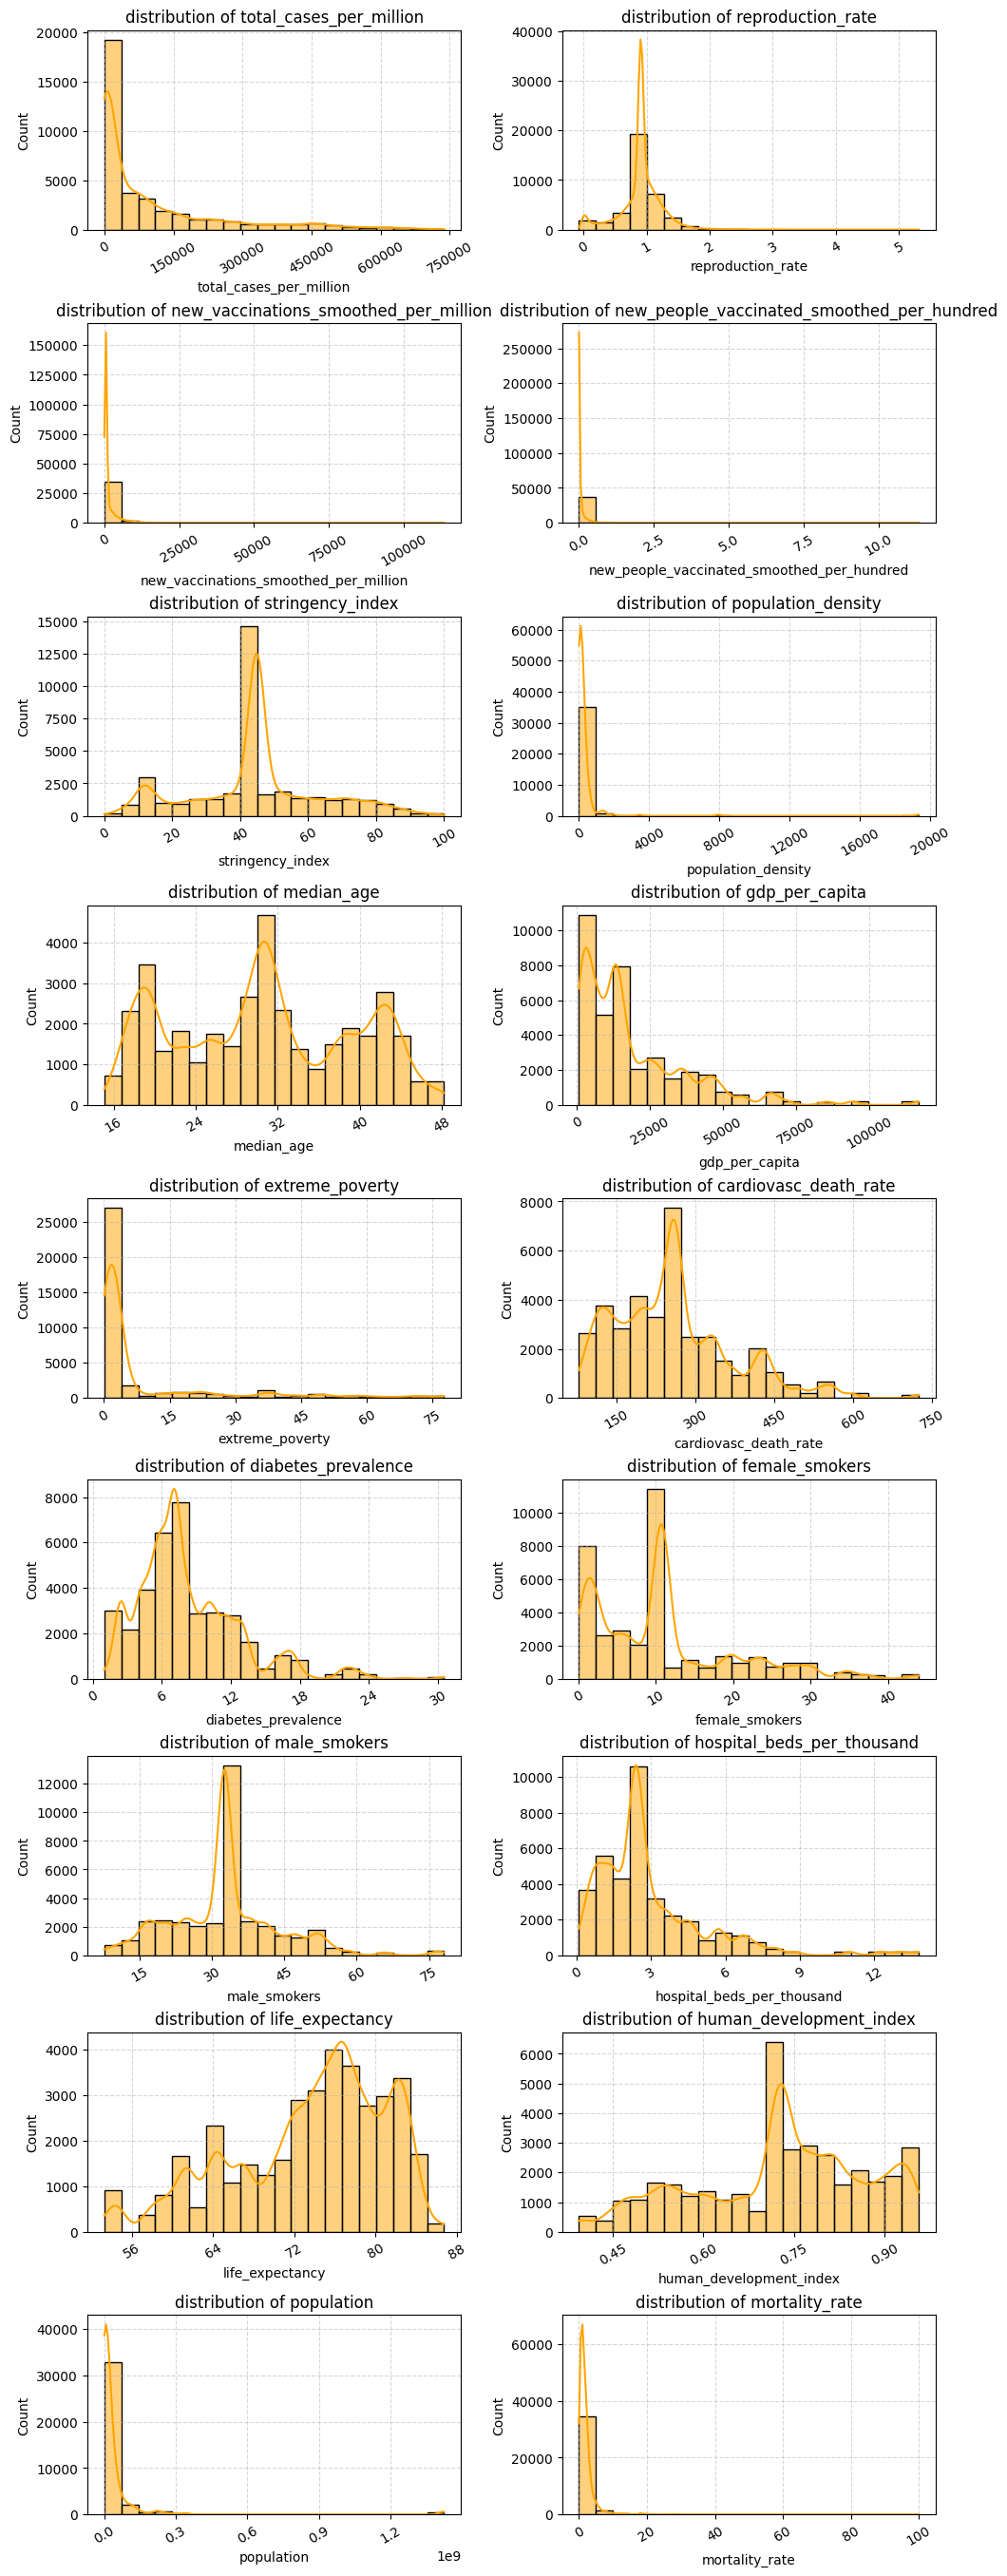

In [31]:
# Visualize distributions of numerical features
plot_cols = [col for col in num_cols if col != 'date']
n = len(plot_cols)
fig, axes = plt.subplots(nrows=(n+1)//2, ncols=2, figsize=(10, 3*((n+1)//2)), constrained_layout=True)
axes = axes.flatten()

for ax, col in zip(axes, plot_cols):
    data = copy_df[col].dropna()
    sns.histplot(data, bins=20, kde=True, ax=ax, color='orange')
    ax.set_title(f"distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    if len(data.unique()) > 10:
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=6))
    ax.tick_params(axis='x', labelrotation=30)
    ax.grid(True, linestyle='--', alpha=0.5)

for ax in axes[n:]:
    ax.set_visible(False)

### Observations
- Mortality is right-skewed, meaning most countries have low COVID-19 mortality rates, but a few have much higher rates. This means that while the pandemic affected everyone, the impact was much more severe in some places.
- Population features (like median age, population density, and GDP per capita) are not evenly spread. Most countries have younger populations, lower densities, and lower incomes, but a few countries are much older, more crowded, or wealthier.
- Health indicators (like diabetes prevalence and hospital beds) also show big differences. Some countries have much better healthcare resources than others.

## Extract Month and Year

In [32]:
copy_df['month'] = copy_df['date'].dt.month_name()
copy_df['year'] = copy_df['date'].dt.year  
copy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36653 entries, 0 to 39387
Data columns (total 22 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   continent                                   36653 non-null  object        
 1   date                                        36653 non-null  datetime64[ns]
 2   total_cases_per_million                     36653 non-null  float64       
 3   reproduction_rate                           36653 non-null  float64       
 4   new_vaccinations_smoothed_per_million       36653 non-null  float64       
 5   new_people_vaccinated_smoothed_per_hundred  36653 non-null  float64       
 6   stringency_index                            36653 non-null  float64       
 7   population_density                          36653 non-null  float64       
 8   median_age                                  36653 non-null  float64       
 9   gdp_per_cap

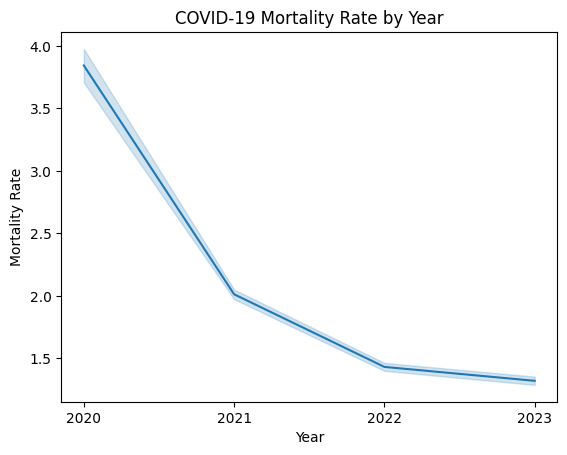

In [33]:
sns.lineplot(data=copy_df, x='year', y='mortality_rate')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(sorted(copy_df['year'].unique())) 
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.title('COVID-19 Mortality Rate by Year')
plt.show();

### Observations

-Fewer people died from COVID-19 compared to earlier years, possibly due to better treatments, or public health measures.

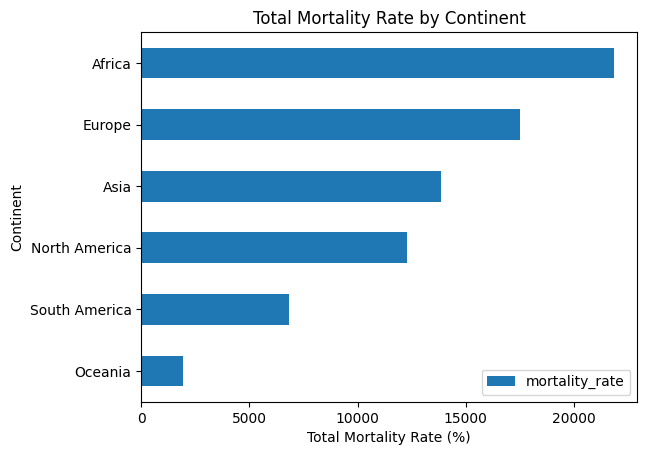

In [34]:
copy_df.groupby(['continent'])['mortality_rate',].sum().sort_values(['mortality_rate']).plot(kind='barh')
plt.xlabel('Total Mortality Rate (%)')
plt.ylabel('Continent')
plt.title('Total Mortality Rate by Continent');

### Observations

- African and European countries experienced more deaths relative to their number of cases.
- Oceania experienced the least Mortality rate

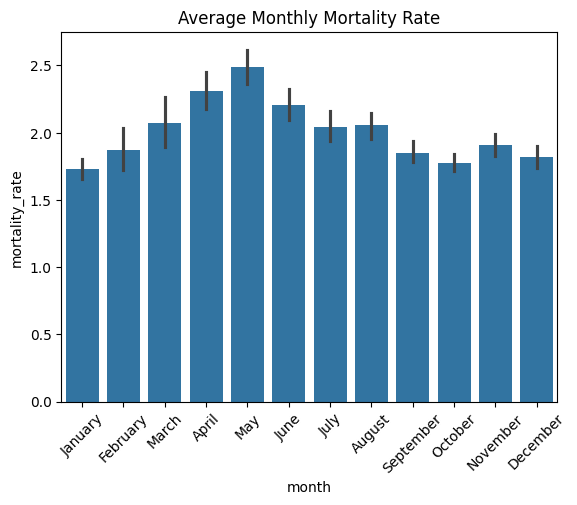

In [35]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax = sns.barplot(data=copy_df, x='month', y='mortality_rate', order=months)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('Average Monthly Mortality Rate');


### Observations
 - The mortality rate changes from month to month, with mortality rate highest in **April, May and June**.

In [36]:
copy_df.columns

Index(['continent', 'date', 'total_cases_per_million', 'reproduction_rate',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population', 'mortality_rate', 'month',
       'year'],
      dtype='object')

In [37]:
# ax = sns.histplot(data=copy_df, x = 'hospital_beds_per_thousand', hue = 'mortality_rate')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [38]:
# drop 'date' from num_cols if present
if 'date' in num_cols:
	num_cols.remove('date')

#### Check Correlation between Numeric Features

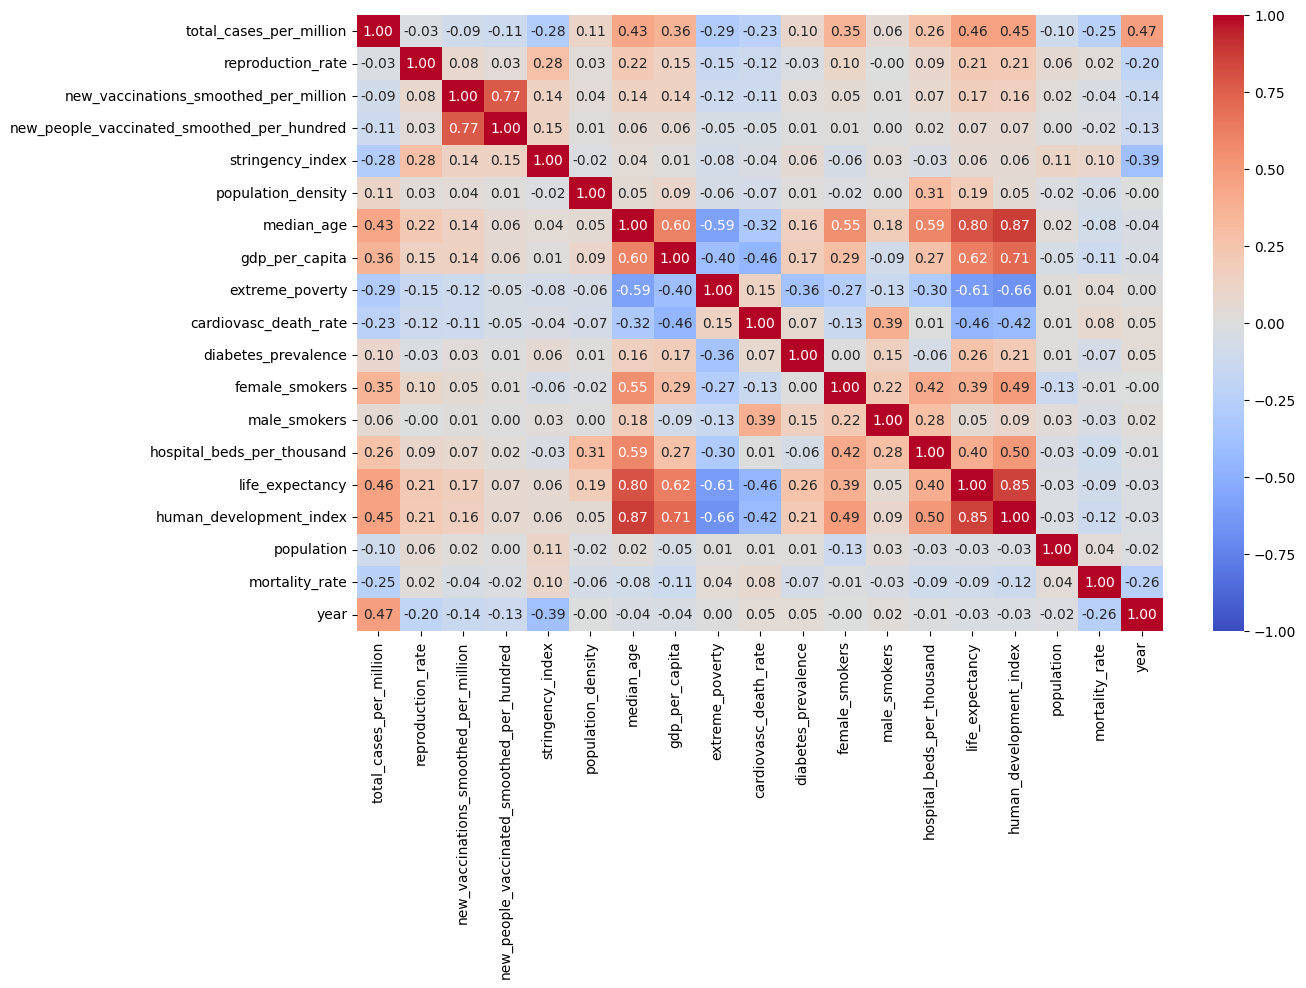

In [39]:
plt.figure(figsize=(13, 8))
sns.heatmap(copy_df.select_dtypes('number').corr(), annot = True, vmax=1, vmin=-1, center=0, cmap='coolwarm', fmt=".2f");

### Observations

- Year has moderately strong correlation with features like total cases because the number increase over time. This means as time goes on, the cumulative counts get larger.
- Mortality rate is slightly negatively correlated with date, suggesting that the proportion of deaths to cases fall over time.

## Data Transformation

#### Split data

In [40]:
LABEL = 'mortality_rate'
X = new_df.drop(columns = [LABEL, 'date'], axis = 1)
y = new_df[LABEL]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25657, 18)
(25657,)
(10996, 18)
(10996,)


In [43]:
y_train.head()

31107   0.56
2564    2.24
9598    0.96
8740    3.94
8375    0.40
Name: mortality_rate, dtype: float64

In [44]:
num_features = new_df.select_dtypes('number').drop('mortality_rate', axis = 1).columns.tolist()
cat_features = ['continent']

In [45]:
pt = PowerTransformer(method = 'yeo-johnson', standardize= False)

In [46]:
X_train.head()

,continent,total_cases_per_million,reproduction_rate,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index,population
31107,Europe,629300.77,1.11,653.43,0.02,5.56,556.67,30.65,56861.47,2.20,257.00,5.64,10.76,32.61,3.80,84.97,0.73,33690.00
2564,North America,90813.24,0.95,747.71,0.01,23.15,39.50,34.30,27717.85,2.20,235.95,13.17,3.10,20.40,2.90,73.92,0.81,409989.00
9598,Europe,400296.17,0.80,157.29,0.00,14.81,137.18,43.30,32605.91,2.20,227.48,6.82,30.50,38.30,6.63,79.38,0.90,10493990.00
8740,Europe,527.78,0.82,653.43,0.02,89.81,73.73,44.00,22669.80,0.70,253.78,5.59,34.30,39.90,5.54,78.49,0.85,4030361.00
8375,North America,1089.45,1.40,653.43,0.02,73.61,96.08,33.60,15525.00,1.30,137.97,8.78,6.40,17.40,1.13,80.28,0.81,5180836.00


In [47]:
X_train_copy = X_train.copy()

In [48]:
# Remove 'continent' from the copied data, transform numeric features, then add 'continent' back
X_num = X_train_copy.drop(columns= cat_features)
X_num_transformed = pt.fit_transform(X_num)
X_transformed = pd.DataFrame(X_num_transformed, columns=X_num.columns, index=X_num.index)
X_transformed = X_transformed.assign(continent=X_train_copy[cat_features])

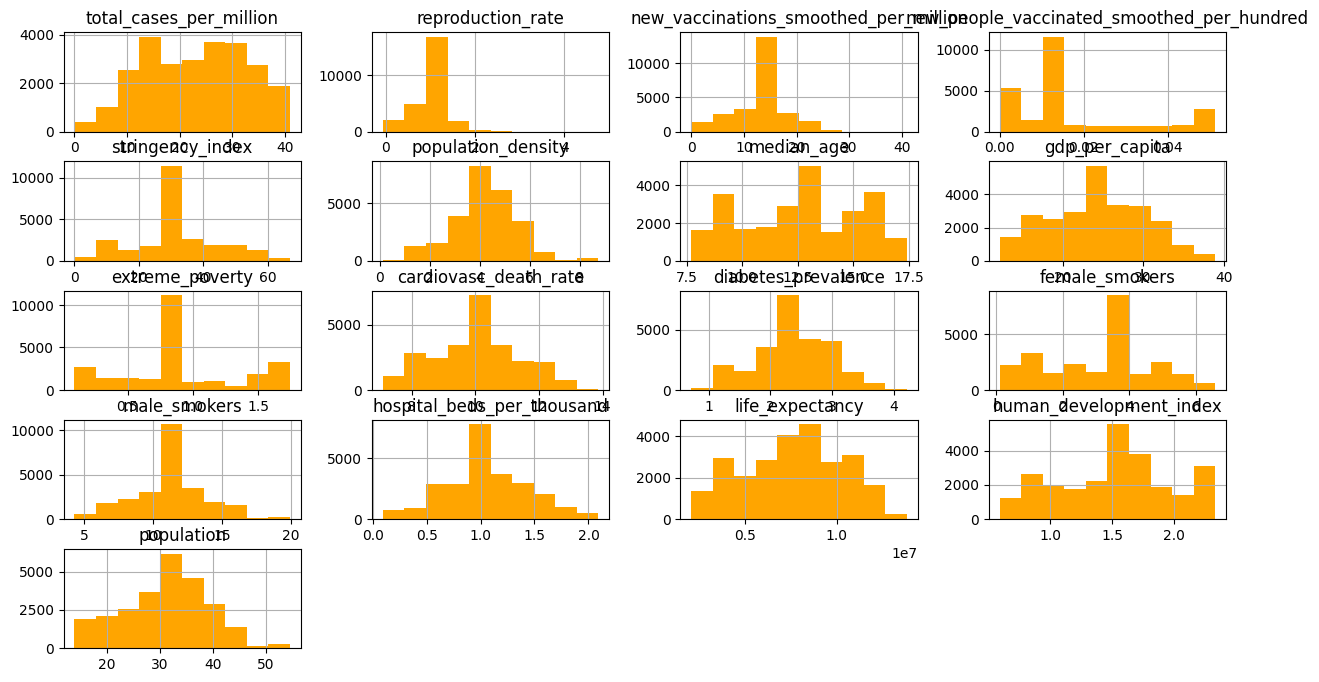

In [49]:
# quick look at transformed features
X_transformed.hist(color ='orange', figsize=(15, 8));

###  Correlation after Power Transformation

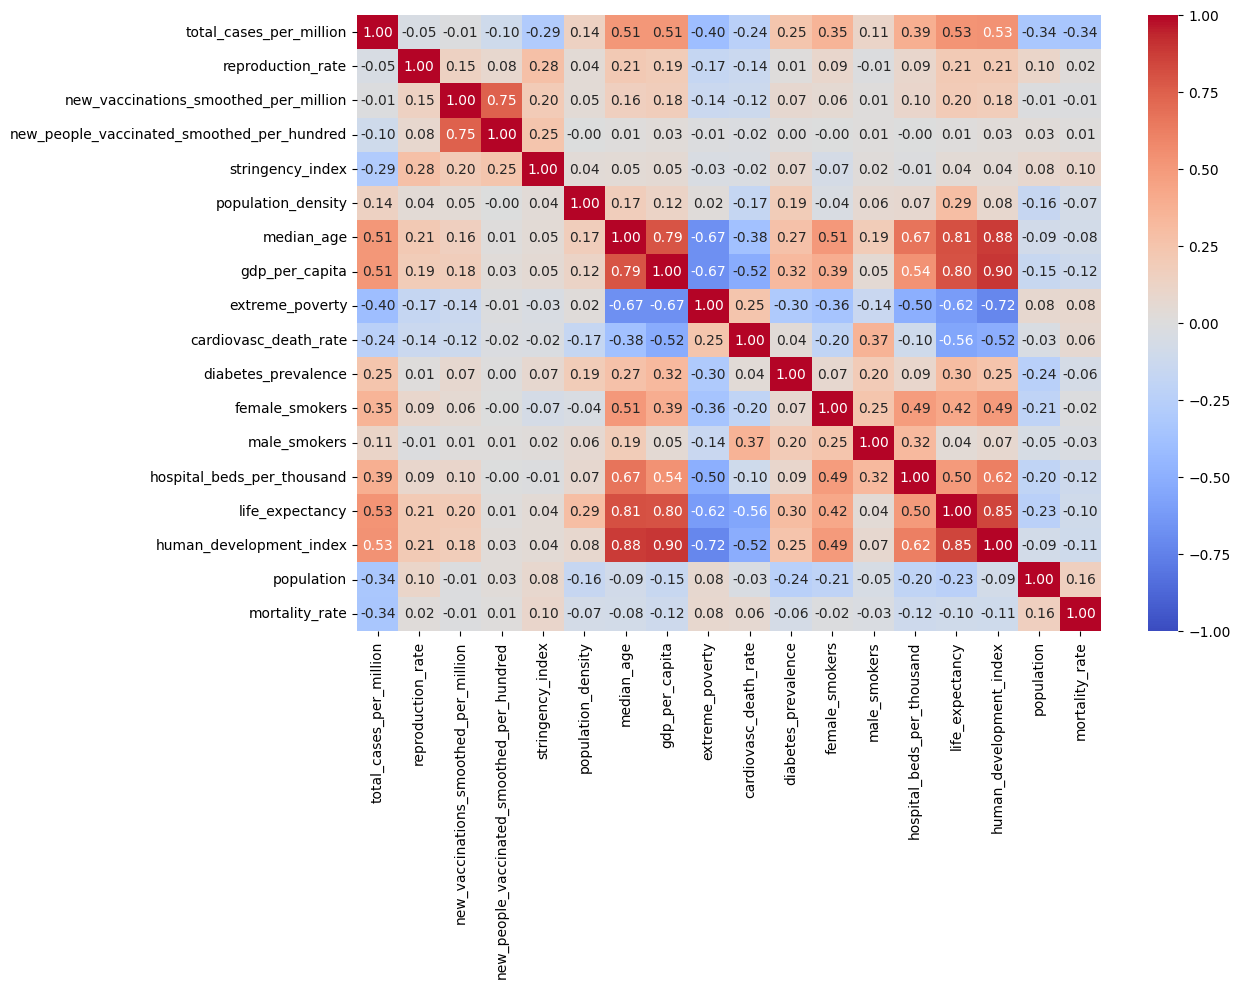

In [50]:
plt.figure(figsize=(12, 8))
corr = X_transformed.select_dtypes('number').assign(mortality_rate=y_train)
sns.heatmap(corr.corr(), annot = True, vmax=1, vmin=-1, center=0, fmt=".2f", cmap = 'coolwarm');

In [51]:

# Numerical pipeline: PowerTransformer + StandardScaler
num_pipeline = Pipeline([
    ("power", PowerTransformer()),
    ("scaler", StandardScaler())
])

# Categorical pipeline: Label Encoding (use OrdinalEncoder inside CT)
cat_pipeline = Pipeline([
    ("ordinal", OrdinalEncoder())
])

In [52]:
# Combine with ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

## Model Selection

In [53]:
# Models
models = {
    "decisiontree": DecisionTreeRegressor(random_state=42),
    "randomforest": RandomForestRegressor(random_state=42),
    "gradientboosting": GradientBoostingRegressor(random_state=42),
    "xgboost": XGBRegressor(random_state=42, verbosity=0)
}


In [54]:
results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = -cross_val_score(pipe, X_train, y_train, cv= kf, scoring="neg_root_mean_squared_error")
    results[name] = scores

print("CV Results:", results)

CV Results: {'decisiontree': array([1.70958897, 1.64857666, 1.66716657, 2.50690299, 1.19338603]), 'randomforest': array([1.24854665, 1.63114983, 1.02262092, 2.33616168, 1.07658606]), 'gradientboosting': array([1.72952551, 2.32442809, 1.50132039, 2.76720526, 1.89419832]), 'xgboost': array([1.92173221, 1.7752771 , 0.89871053, 2.44991819, 1.11228373])}


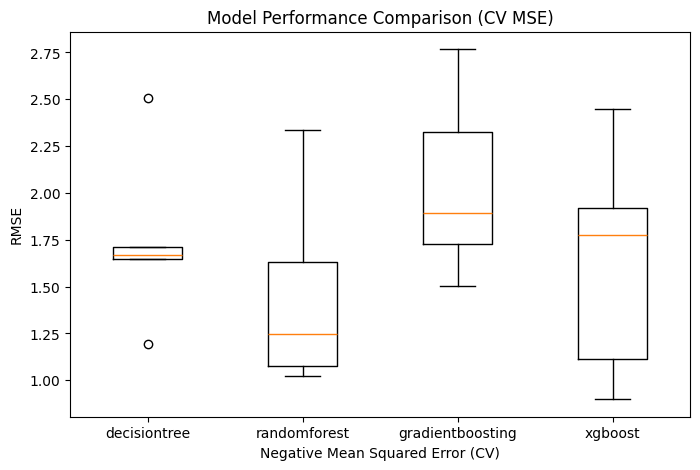

In [55]:
plt.figure(figsize=(8, 5))
plt.boxplot([results[name] for name in results.keys()], labels=list(results.keys()))
plt.xlabel("Negative Mean Squared Error (CV)")
plt.ylabel("RMSE")
plt.title("Model Performance Comparison (CV MSE)")
plt.show()

In [58]:
dt = Pipeline([
    ("preprocess", preprocessor),
    ("model", DecisionTreeRegressor(random_state=42))
])
dt.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [64]:
pred = dt.predict(X_train)
mse = mean_squared_error(y_train, pred)
rmse = np.sqrt(mse)
print(f"training_loss is {rmse}")

training_loss is 0.011898038256634273


In [68]:
# Decision Tree hyperparameter tuning
dt_params = {
    'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [2, 5, 10]
}
dt_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", DecisionTreeRegressor(random_state=42))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
dt_grid = GridSearchCV(dt_pipe, dt_params, cv=kf, scoring='neg_root_mean_squared_error')
dt_grid.fit(X_train, y_train)
print("Best Decision Tree Params:", dt_grid.best_params_)
print("Best Decision Tree Score:", -dt_grid.best_score_)
best_dt_model = dt_grid.best_estimator_

Best Decision Tree Params: {'model__max_depth': 10, 'model__min_samples_split': 5}
Best Decision Tree Score: 1.889867116712119


In [70]:
dt_importances = best_dt_model.named_steps['model'].feature_importances_
feature_names = num_features + cat_features

In [75]:
dt_feature_importances = pd.Series(dt_importances, index=feature_names).sort_values()


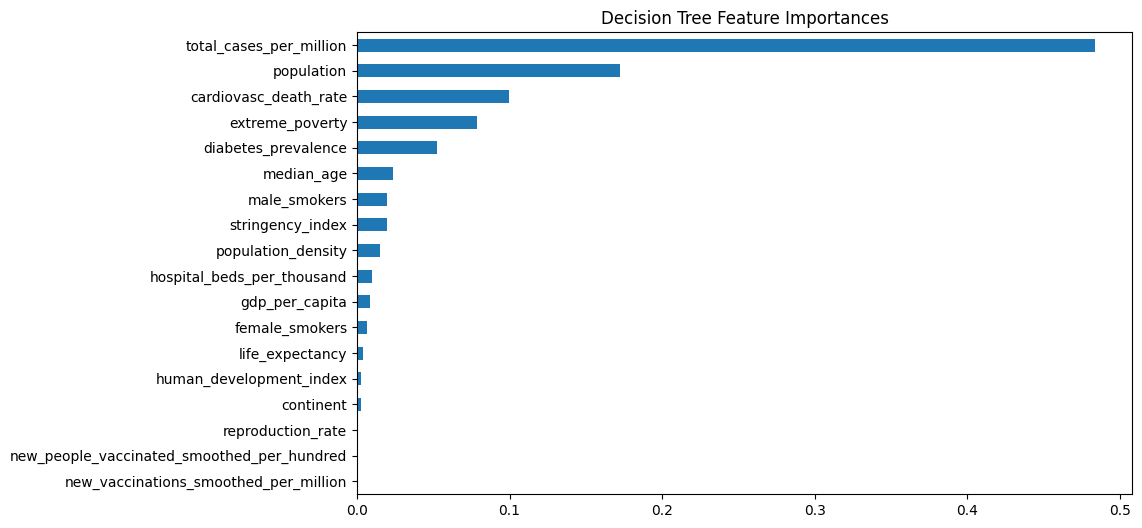

In [76]:
plt.figure(figsize=(8,5))
dt_feature_importances.plot(kind='barh', figsize=(10, 6))
plt.title('Decision Tree Feature Importances')
plt.show()

In [78]:
# Predict on test set using the best decision tree model
y_pred_dt = best_dt_model.predict(X_test)

# Calculate RMSE
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print(f"Decision Tree Test RMSE: {rmse_dt:.3f}")

Decision Tree Test RMSE: 2.002


In [81]:
with open('models/best_dt_model.pkl', 'wb') as f:
    pickle.dump(best_dt_model, f)

## Conclusion
- **Training RMSE:** 1.88
- **Testing RMSE:** 2.00

The comparison between training and testing RMSE shows how well the model generalizes:
- Both scores are similar, meaning the model generalizes well to new, unseen data.